## Classification

#### Import packages/library dan Setup

In [3]:
# Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             ConfusionMatrixDisplay, roc_curve, precision_recall_curve)

from xgboost import XGBClassifier
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

sns.set(style='whitegrid')

#### Data loading dan EDA

In [4]:
from google.colab import drive
drive.mount('/content/drive')

# Load Dataset
dtypes = {
    'Airline': 'category',
    'Origin': 'category',
    'Destination': 'category',
    'DelayReason': 'category',
    'FlightNumber': 'int32',
    'Distance': 'float32'
}

df = pd.read_csv(
    "/content/drive/MyDrive/Penggalian Data/flight_delays.csv",
    dtype=dtypes,
    parse_dates=['ScheduledDeparture'],
    infer_datetime_format=True
)

Mounted at /content/drive


<ipython-input-4-f0afc91bcd92>:14: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(


In [5]:
from IPython.display import display
display(df)

,FlightID,Airline,FlightNumber,Origin,Destination,ScheduledDeparture,ActualDeparture,ScheduledArrival,ActualArrival,DelayMinutes,DelayReason,Cancelled,Diverted,AircraftType,TailNumber,Distance
0,1,United,4558,ORD,MIA,2024-09-01 08:11:00,2024-09-01 08:30,2024-09-01 12:11,2024-09-01 12:19,8,Weather,True,False,Boeing 737,N71066,1031.0
1,2,Delta,8021,LAX,MIA,2024-09-01 10:25:00,2024-09-01 10:41,2024-09-01 13:25,2024-09-01 13:27,2,Air Traffic Control,True,True,Airbus A320,N22657,1006.0
2,3,Southwest,7520,DFW,SFO,2024-09-01 16:53:00,2024-09-01 17:05,2024-09-01 17:53,2024-09-01 18:07,14,Weather,True,True,Boeing 737,N95611,2980.0
3,4,Delta,2046,ORD,BOS,2024-09-01 14:44:00,2024-09-01 15:04,2024-09-01 18:44,2024-09-01 18:34,-10,NaN,False,False,Boeing 777,N90029,1408.0
4,5,Delta,6049,LAX,SEA,2024-09-01 01:51:00,2024-09-01 02:08,2024-09-01 05:51,2024-09-01 06:15,24,Air Traffic Control,False,True,Boeing 737,N27417,2298.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747622,1747623,United,4145,DFW,MIA,2024-09-01 12:46:00,2024-09-01 12:54,2024-09-01 17:46,2024-09-01 17:41,-5,NaN,False,True,Boeing 737,N19796,2396.0
1747623,1747624,United,2155,ATL,SEA,2024-09-01 20:43:00,2024-09-01 20:54,2024-09-01 21:43,2024-09-01 22:03,20,Weather,True,False,Boeing 777,N68154,2185.0
1747624,1747625,Delta,4878,JFK,SFO,2024-09-01 03:26:00,2024-09-01 03:47,2024-09-01 06:26,2024-09-01 06:20,-6,NaN,False,False,Boeing 777,N18964,361.0
1747625,1747626,Delta,2940,JFK,SEA,2024-09-01 08:04:00,2024-09-01 08:07,2024-09-01 13:04,2024-09-01 13:20,16,Maintenance,False,True,Airbus A320,N94591,2793.0


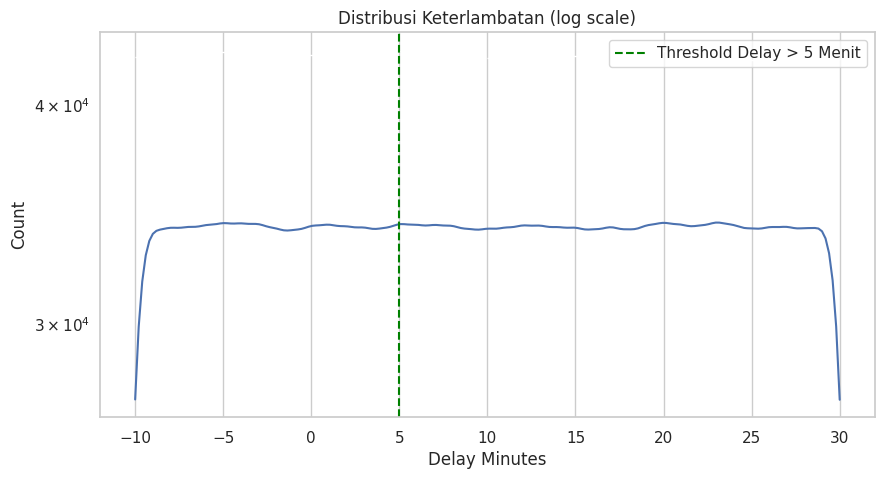

In [6]:
# Distribusi Delay
plt.figure(figsize=(10,5))
sns.histplot(df['DelayMinutes'], bins=50, kde=True, log_scale=(False, True))
plt.axvline(5, color='green', linestyle='--', label='Threshold Delay > 5 Menit')
plt.title("Distribusi Keterlambatan (log scale)")
plt.xlabel("Delay Minutes")
plt.legend()
plt.show()

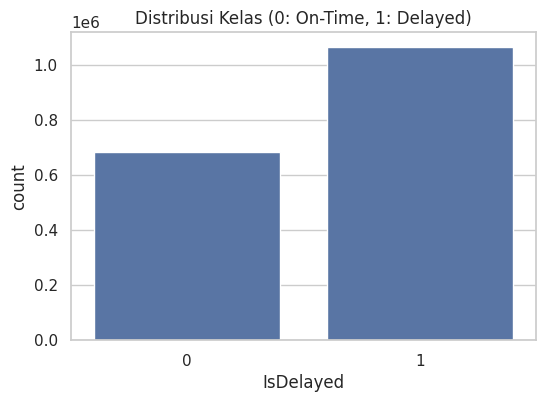

In [7]:
# Label Biner Delay (>5 Menit)
threshold = 5
df['IsDelayed'] = (df['DelayMinutes'] > threshold).astype(int)

# Visualisasi Kelas
plt.figure(figsize=(6,4))
sns.countplot(x='IsDelayed', data=df)
plt.title("Distribusi Kelas (0: On-Time, 1: Delayed)")
plt.show()

#### Feature Engineering

In [8]:
# Ekstraksi Fitur Temporal
def extract_time_features(df):
    df['DepHour'] = df['ScheduledDeparture'].dt.hour
    df['DayOfWeek'] = df['ScheduledDeparture'].dt.dayofweek
    df['Month'] = df['ScheduledDeparture'].dt.month
    df['Quarter'] = df['ScheduledDeparture'].dt.quarter
    df['WeekOfYear'] = df['ScheduledDeparture'].dt.isocalendar().week
    df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['DayPeriod'] = pd.cut(df['DepHour'], bins=[0,6,12,18,24],
                             labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
    return df.drop(columns=['ScheduledDeparture'])

df = extract_time_features(df)

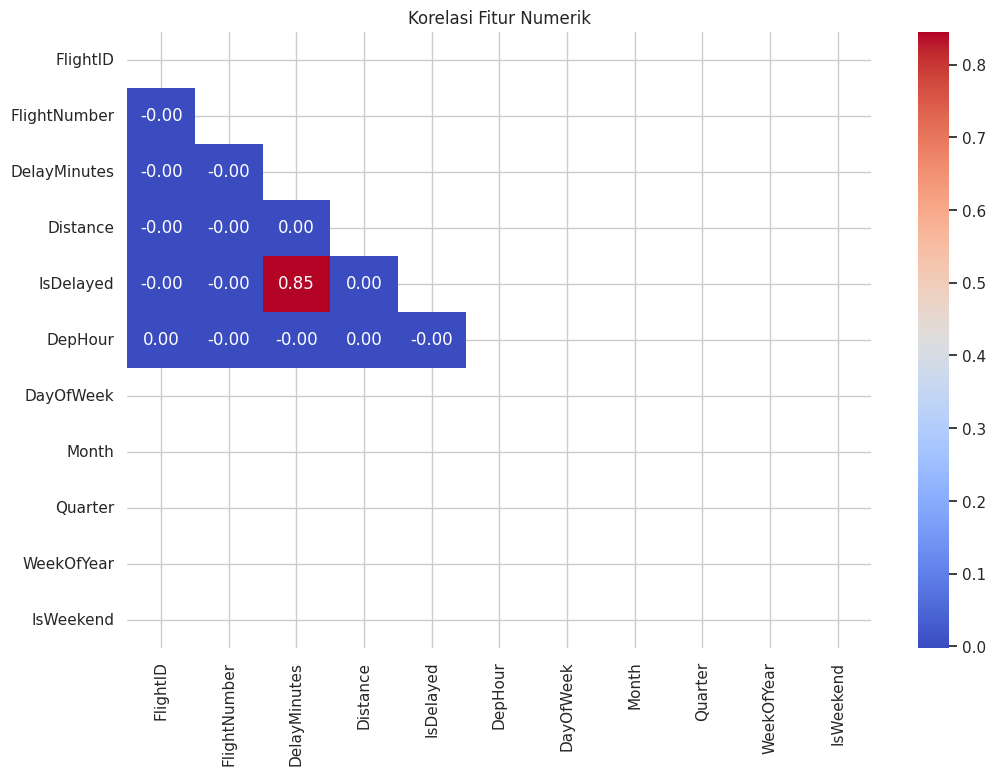

In [9]:
# Korelasi Fitur Numerik
corr = df.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12,8))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Korelasi Fitur Numerik")
plt.show()

#### Data Pipeline dan Training Model

In [10]:
# Features
num_feat = ['FlightNumber', 'Distance', 'DepHour', 'WeekOfYear']
cat_feat = ['Airline', 'Origin', 'Destination', 'DelayReason', 'DayPeriod']

X = df[num_feat + cat_feat].copy()
y = df['IsDelayed']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Pipeline Preprocessing
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_feat),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feat)
])

# Pipeline Model
model = make_pipeline(
    preproc,
    SMOTE(random_state=42),
    XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
)

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['FlightNumber', 'Distance',
                                                   'DepHour', 'WeekOfYear']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Airline', 'Origin',
                                                   'Destination', 'DelayReason',
                                                   'DayPeriod'])])),
                ('smote', SMOTE(random_state=42)),
                ('xgbclassifier',
                 XGBClassifier(base_score...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

#### Evaluasi Model

Classification Report:

              precision    recall  f1-score   support

     On-Time       1.00      0.69      0.82    136429
     Delayed       0.83      1.00      0.91    213097

    accuracy                           0.88    349526
   macro avg       0.92      0.84      0.86    349526
weighted avg       0.90      0.88      0.87    349526

ROC-AUC: 0.8447


<Figure size 600x500 with 0 Axes>

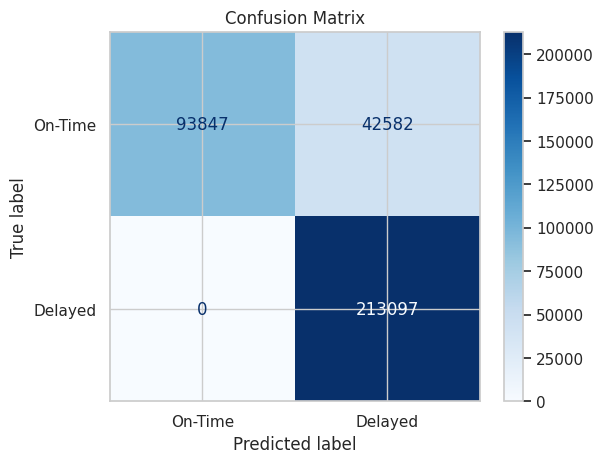

In [11]:
# Evaluasi
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["On-Time", "Delayed"]))

print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Confusion Matrix
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["On-Time", "Delayed"], cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

#### Feature Importance

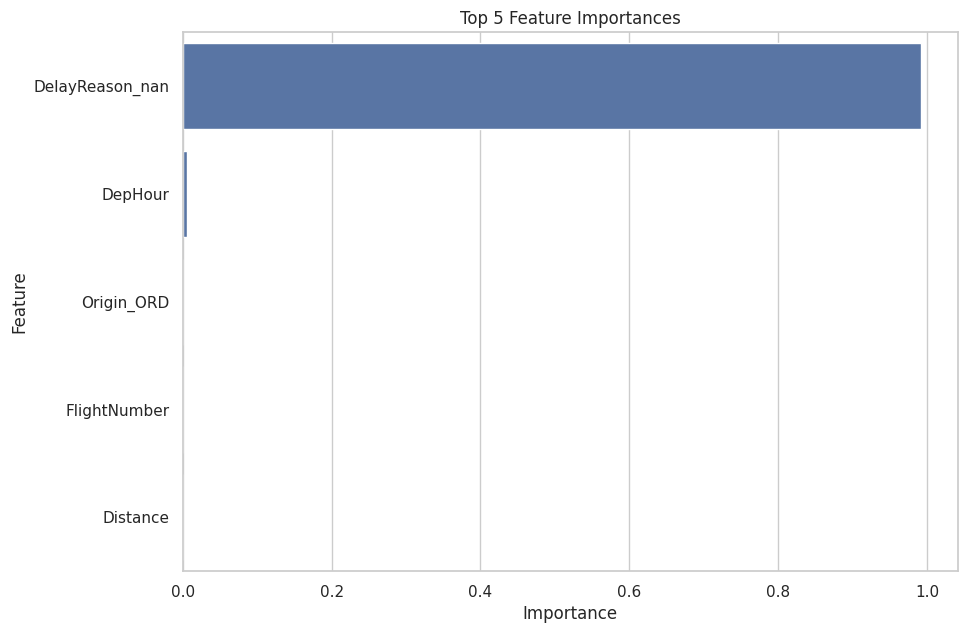

In [12]:
# Feature Importance
feat_num = num_feat
feat_cat = model.named_steps['columntransformer'].named_transformers_['cat']\
    .get_feature_names_out(cat_feat).tolist()

all_feat = feat_num + feat_cat
importances = model.named_steps['xgbclassifier'].feature_importances_

imp_df = pd.DataFrame({'Feature': all_feat, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False).head(5)

plt.figure(figsize=(10,7))
sns.barplot(x='Importance', y='Feature', data=imp_df)
plt.title("Top 5 Feature Importances")
plt.show()

#### Error Analysis Classification

Total misclassified: 42582

Error Type Distribution:
 Predicted      1
Actual          
0          42582


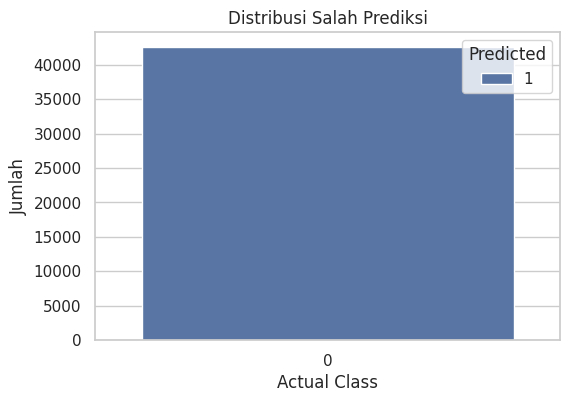

In [13]:
# Analisis Error
X_test_ = X_test.copy()
X_test_['Actual'] = y_test
X_test_['Predicted'] = y_pred

# Salah klasifikasi
errors = X_test_[X_test_['Actual'] != X_test_['Predicted']]
print(f"Total misclassified: {len(errors)}")

# Distribusi jenis error
conf = pd.crosstab(errors['Actual'], errors['Predicted'], rownames=['Actual'], colnames=['Predicted'])
print("\nError Type Distribution:\n", conf)

# Visualisasi
plt.figure(figsize=(6,4))
sns.countplot(x='Actual', hue='Predicted', data=errors)
plt.title("Distribusi Salah Prediksi")
plt.xlabel("Actual Class")
plt.ylabel("Jumlah")
plt.legend(title="Predicted")
plt.show()

In [14]:
# Data misclassified
print("Contoh 10 Baris Misclassified:")
display(errors.head(10))

Contoh 10 Baris Misclassified:


,FlightNumber,Distance,DepHour,WeekOfYear,Airline,Origin,Destination,DelayReason,DayPeriod,Actual,Predicted
578454,7794,356.0,2,35,United,JFK,MIA,Maintenance,Night,0,1
631811,7352,2649.0,18,35,United,LAX,SFO,Maintenance,Evening,0,1
736708,9021,2659.0,10,35,American Airlines,LAX,BOS,Maintenance,Morning,0,1
1000188,1956,460.0,4,35,Southwest,ATL,BOS,Air Traffic Control,Night,0,1
1694760,6930,1339.0,5,35,Southwest,ORD,BOS,Air Traffic Control,Night,0,1
852442,4167,1202.0,4,35,American Airlines,JFK,SEA,Air Traffic Control,Night,0,1
1555600,2424,1970.0,12,35,Southwest,ATL,JFK,Weather,Afternoon,0,1
1305667,9517,2835.0,4,35,Southwest,ATL,BOS,Weather,Night,0,1
1683388,7577,2437.0,20,35,United,LAX,MIA,Maintenance,Evening,0,1
511321,2055,2280.0,16,35,American Airlines,JFK,SFO,Maintenance,Afternoon,0,1


In [15]:
# Distribusi Fitur Kategorikal Utama pada Data Salah Klasifikasi
print("Distribusi Maskapai pada Data Salah Klasifikasi:")
print(errors['Airline'].value_counts().head())

Distribusi Maskapai pada Data Salah Klasifikasi:
Airline
American Airlines    10776
Southwest            10721
United               10565
Delta                10520
Name: count, dtype: int64


In [16]:
print("Distribusi Bandara Asal (Origin) pada Data Salah Klasifikasi:")
print(errors['Origin'].value_counts().head())

Distribusi Bandara Asal (Origin) pada Data Salah Klasifikasi:
Origin
ORD    8587
ATL    8553
JFK    8504
LAX    8494
DFW    8444
Name: count, dtype: int64


In [17]:
print("Distribusi Bandara Tujuan (Destination) pada Data Salah Klasifikasi:")
print(errors['Destination'].value_counts().head())

Distribusi Bandara Tujuan (Destination) pada Data Salah Klasifikasi:
Destination
MIA    8682
JFK    8584
BOS    8486
SEA    8471
SFO    8359
Name: count, dtype: int64


In [18]:
# Statistik fitur numerik pada data salah klasifikasi
print("Statistik Deskriptif Fitur Numerik pada Data Salah Klasifikasi:")
print(errors[num_feat].describe())

Statistik Deskriptif Fitur Numerik pada Data Salah Klasifikasi:
       FlightNumber      Distance       DepHour  WeekOfYear
count  42582.000000  42582.000000  42582.000000     42582.0
mean    5019.801724   1552.668579     11.547438        35.0
std     2878.865442    836.412903      6.911977         0.0
min        1.000000    100.000000      0.000000        35.0
25%     2541.000000    826.000000      6.000000        35.0
50%     5032.000000   1554.000000     12.000000        35.0
75%     7509.750000   2279.000000     18.000000        35.0
max     9999.000000   3000.000000     23.000000        35.0


#### Save dan Model Inference

In [19]:
# Simpan model dan preprocessor
joblib.dump(model, 'xgb_flight_model.pkl')

# Inference Function
def predict_delay(input_dict):
    sample = pd.DataFrame([input_dict])
    sample['ScheduledDeparture'] = pd.to_datetime(sample['ScheduledDeparture'])
    sample = extract_time_features(sample)
    X_infer = sample[num_feat + cat_feat]

    pred = model.predict(X_infer)[0]
    prob = model.predict_proba(X_infer)[0][1]

    return {
        'prediction': 'Delayed' if pred == 1 else 'On-Time',
        'probability': round(prob, 4)
    }

# Contoh
sample_input = {
    'Airline': 'Garuda Indonesia',
    'Origin': 'CGK',
    'Destination': 'DPS',
    'DelayReason': 'Weather',
    'FlightNumber': 1234,
    'Distance': 800.0,
    'ScheduledDeparture': '2024-08-15 14:30:00'
}

result = predict_delay(sample_input)
print("\nHasil Prediksi:")
print(f"Status: {result['prediction']}")
print(f"Probabilitas Delay: {result['probability']:.2%}")


Hasil Prediksi:
Status: Delayed
Probabilitas Delay: 80.98%


### Regression

#### Import packages/library

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import chisquare

from xgboost import XGBRegressor

sns.set(style="whitegrid")

#### Load data dan fitur waktu

In [21]:
# Load data
df = pd.read_csv(
    "/content/drive/MyDrive/Penggalian Data/flight_delays.csv",
    dtype={
        'Airline': 'category',
        'Origin': 'category',
        'Destination': 'category',
        'DelayReason': 'category',
        'FlightNumber': 'int32',
        'Distance': 'float32'
    },
    parse_dates=['ScheduledDeparture']
)

# Ekstraksi fitur waktu
def extract_time_features(df):
    df['DepHour'] = df['ScheduledDeparture'].dt.hour
    df['DayOfWeek'] = df['ScheduledDeparture'].dt.dayofweek
    df['Month'] = df['ScheduledDeparture'].dt.month
    df['Quarter'] = df['ScheduledDeparture'].dt.quarter
    df['WeekOfYear'] = df['ScheduledDeparture'].dt.isocalendar().week
    df['IsWeekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['DayPeriod'] = pd.cut(df['DepHour'], bins=[0,6,12,18,24],
                             labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
    return df.drop(columns=['ScheduledDeparture'])

df = extract_time_features(df)

#### Feature dan Target

In [22]:
# Definisi fitur dan target
num_feat = ['FlightNumber', 'Distance', 'DepHour', 'WeekOfYear']
cat_feat = ['Airline', 'Origin', 'Destination', 'DelayReason', 'DayPeriod']

X = df[num_feat + cat_feat].copy()
y = df['DelayMinutes']  # Target numerik

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

#### Pipeline dan Model Training

In [23]:
# Pipeline preprocessing
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_feat),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feat)
])

# Pipeline regresi
reg_model = Pipeline([
    ('preproc', preproc),
    ('regressor', XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ))
])

# Train model
reg_model.fit(X_train, y_train)

# Save model
joblib.dump(reg_model, 'xgb_delay_regressor.pkl')

['xgb_delay_regressor.pkl']

#### Evaluasi dan Error Analisis

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Prediksi
y_pred = reg_model.predict(X_test)

# Evaluasi Eror
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE        : {rmse:.2f}")
print(f"R-squared   : {r2:.4f}")
print(f"MAE         : {mae:.2f}")

RMSE        : 7.59
R-squared   : 0.5891
MAE         : 6.22


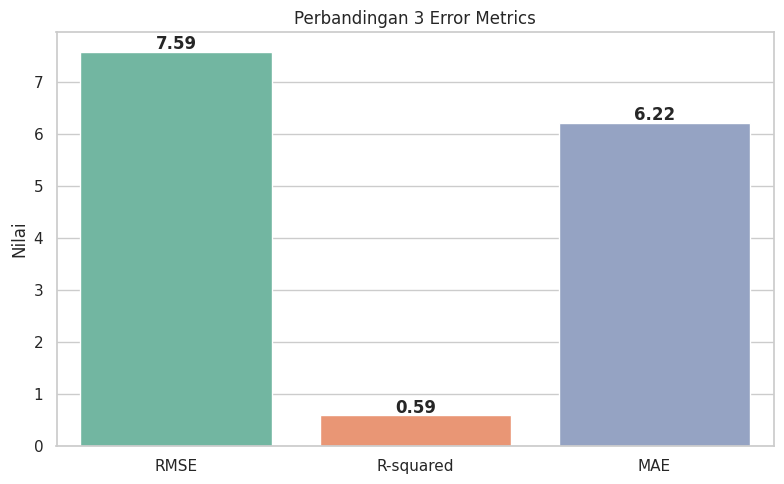

In [25]:
# Bar Plot 3 Error Metrics
metrics = ['RMSE', 'R-squared', 'MAE']
values = [rmse, r2, mae]

plt.figure(figsize=(8,5))
sns.barplot(x=metrics, y=values, palette='Set2', hue=metrics, legend=False)
plt.title("Perbandingan 3 Error Metrics")
for i, v in enumerate(values):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', fontweight='bold')
plt.ylabel("Nilai")
plt.tight_layout()
plt.show()

In [26]:
# Hitung error (residual)
error = y_test - y_pred
abs_error = np.abs(error)

# Gabungkan ke dalam dataframe
error_df = X_test.copy()
error_df['Actual'] = y_test
error_df['Predicted'] = y_pred
error_df['Error'] = error
error_df['AbsError'] = abs_error

# Sort by absolute error
top_errors = error_df.sort_values(by='AbsError', ascending=False).head(10)
print("10 Prediksi dengan Kesalahan Terbesar:")
display(top_errors)

10 Prediksi dengan Kesalahan Terbesar:


,FlightNumber,Distance,DepHour,WeekOfYear,Airline,Origin,Destination,DelayReason,DayPeriod,Actual,Predicted,Error,AbsError
702566,66,192.0,11,35,American Airlines,JFK,MIA,Weather,Morning,30,14.465855,15.534145,15.534145
1386379,9614,2988.0,5,35,American Airlines,ATL,SFO,Weather,Night,30,14.470527,15.529473,15.529473
184636,9601,3000.0,4,35,Delta,ATL,SFO,Weather,Night,30,14.501996,15.498004,15.498004
1193808,9989,2838.0,10,35,Southwest,LAX,JFK,Air Traffic Control,Morning,1,16.488037,-15.488037,15.488037
157984,8203,2962.0,0,35,Southwest,ATL,JFK,Maintenance,Night,1,16.474854,-15.474854,15.474854
274011,9281,134.0,0,35,Delta,ATL,BOS,Maintenance,Night,1,16.430611,-15.430611,15.430611
649231,9959,607.0,4,35,Southwest,JFK,SEA,Air Traffic Control,Night,30,14.585996,15.414004,15.414004
1504974,9874,1683.0,4,35,Delta,ORD,SFO,Air Traffic Control,Night,1,16.394093,-15.394093,15.394093
88234,783,2985.0,1,35,American Airlines,LAX,SFO,Air Traffic Control,Night,1,16.375666,-15.375666,15.375666
1207065,9950,1686.0,6,35,Southwest,ATL,BOS,Air Traffic Control,Morning,1,16.358660,-15.358660,15.358660


DelayReason dengan Error Tertinggi:


,count,mean
DelayReason,,
Air Traffic Control,85132,7.526337
Maintenance,85099,7.509808
Weather,84976,7.507206


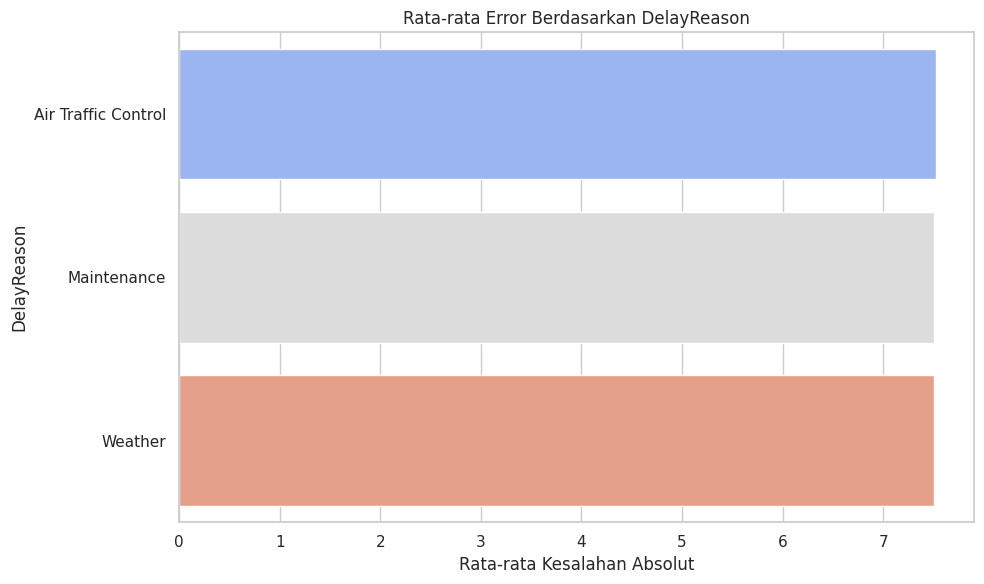

In [27]:
error_df = X_test.copy()
error_df['Actual'] = y_test
error_df['Predicted'] = y_pred
error_df['Error'] = error_df['Actual'] - error_df['Predicted']
error_df['AbsError'] = error_df['Error'].abs()
error_df['DelayReason'] = df.loc[X_test.index, 'DelayReason'].values

# Rata-rata error per DelayReason
group_error = error_df.groupby('DelayReason', observed=False)['AbsError'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)
print("DelayReason dengan Error Tertinggi:")
display(group_error.head(10))

# Visualisasi
plt.figure(figsize=(10,6))
sns.barplot(x='mean', y=group_error.index, data=group_error.reset_index(), palette='coolwarm', hue=group_error.index, legend=False)
plt.xlabel("Rata-rata Kesalahan Absolut")
plt.title("Rata-rata Error Berdasarkan DelayReason")
plt.tight_layout()
plt.show()

#### Model Inference

In [28]:
# Fungsi Inference Regresi
def predict_delay_minutes(input_dict):
    sample = pd.DataFrame([input_dict])
    sample['ScheduledDeparture'] = pd.to_datetime(sample['ScheduledDeparture'])
    sample = extract_time_features(sample)
    sample = sample[num_feat + cat_feat]

    model = joblib.load('xgb_delay_regressor.pkl')
    pred = model.predict(sample)[0]

    return round(pred, 2)

# Contoh penggunaan
sample_input = {
    'Airline': 'Garuda Indonesia',
    'Origin': 'CGK',
    'Destination': 'DPS',
    'DelayReason': 'Weather',
    'FlightNumber': 2345,
    'Distance': 780.0,
    'ScheduledDeparture': '2024-08-15 08:30:00'
}

predicted_delay = predict_delay_minutes(sample_input)
print(f"Prediksi Delay (Menit): {predicted_delay}")

Prediksi Delay (Menit): 15.430000305175781


### Classification & Regression Inference

In [29]:
import pandas as pd
import joblib
from datetime import datetime

# Fungsi bantu ekstraksi waktu
def extract_time_features(df):
    df['DepHour'] = df['ScheduledDeparture'].dt.hour
    df['DayOfWeek'] = df['ScheduledDeparture'].dt.dayofweek
    df['WeekOfYear'] = df['ScheduledDeparture'].dt.isocalendar().week
    df['DayPeriod'] = pd.cut(df['DepHour'], bins=[0,6,12,18,24],
                             labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
    return df

# Fungsi prediksi
def predict_flight(input_data):
    # Konversi input ke DataFrame
    df = pd.DataFrame([input_data])
    df['ScheduledDeparture'] = pd.to_datetime(df['ScheduledDeparture'])
    df = extract_time_features(df)

    # Fitur yang digunakan
    features = ['FlightNumber', 'Distance', 'DepHour', 'WeekOfYear',
                'Airline', 'Origin', 'Destination', 'DelayReason', 'DayPeriod']
    X = df[features]

    # Load model
    clf = joblib.load('xgb_flight_model.pkl')
    reg = joblib.load('xgb_delay_regressor.pkl')

    # Prediksi klasifikasi & regresi
    delay_prob = clf.predict_proba(X)[0][1]
    is_delayed = clf.predict(X)[0]
    delay_time = reg.predict(X)[0]

    # Output
    print("Hasil Prediksi Penerbangan")
    print(f"Status          : {'DELAYED' if is_delayed else 'ON-TIME'}")
    print(f"Probabilitas    : {delay_prob:.2%}")
    print(f"Estimasi Waktu  : {delay_time:.1f} menit")

In [30]:
# Contoh input pengguna
input_data = {
    'Airline': 'Garuda Indonesia',
    'Origin': 'CGK',
    'Destination': 'DPS',
    'DelayReason': 'Weather',
    'FlightNumber': 456,
    'Distance': 800.0,
    'ScheduledDeparture': '2024-08-15 15:00:00'
}

predict_flight(input_data)

Hasil Prediksi Penerbangan
Status          : DELAYED
Probabilitas    : 80.95%
Estimasi Waktu  : 15.6 menit
